# Import tools and libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data import

In [4]:
raw_df = pd.read_csv('data/meas2582.csv')
raw_df.head(100)

,0,1,2,3,4
0,2020-02-26 09:22:37,50648db23c8c813993e01696a9490f1a,319.826,NaN,NaN
1,2020-02-26 13:51:26,50648db23c8c813993e01696a9490f1a,319.844,NaN,NaN
2,2020-02-26 14:00:04,50648db23c8c813993e01696a9490f1a,319.844,NaN,NaN
3,2020-02-26 14:10:38,50648db23c8c813993e01696a9490f1a,319.844,NaN,NaN
4,2020-02-26 14:12:49,50648db23c8c813993e01696a9490f1a,319.844,NaN,NaN
...,...,...,...,...,...
95,2020-02-26 22:08:17,50648db23c8c813993e01696a9490f1a,320.070,NaN,NaN
96,2020-02-26 22:23:17,50648db23c8c813993e01696a9490f1a,320.072,NaN,NaN
97,2020-02-26 22:23:29,50648db23c8c813993e01696a9490f1a,320.072,NaN,NaN
98,2020-02-26 22:27:44,50648db23c8c813993e01696a9490f1a,320.079,NaN,NaN


## Data columns filter and re-indexing

In [5]:
raw_df_filter = raw_df.loc[:, ['0', '2']]
raw_df_filter.columns = ['timestamp', 'value']
raw_df_filter['timestamp'] = pd.to_datetime(raw_df_filter['timestamp'])
raw_df_filter.set_index('timestamp', inplace=True)
raw_df_filter = raw_df_filter[raw_df_filter['value'] != 0]
raw_df_filter.head(10)

,value
timestamp,
2020-02-26 09:22:37,319.826
2020-02-26 13:51:26,319.844
2020-02-26 14:00:04,319.844
2020-02-26 14:10:38,319.844
2020-02-26 14:12:49,319.844
2020-02-26 14:21:30,319.844
2020-02-26 14:21:30,319.844
2020-02-26 14:30:15,319.844
2020-02-26 14:38:29,319.844


<AxesSubplot:xlabel='timestamp'>

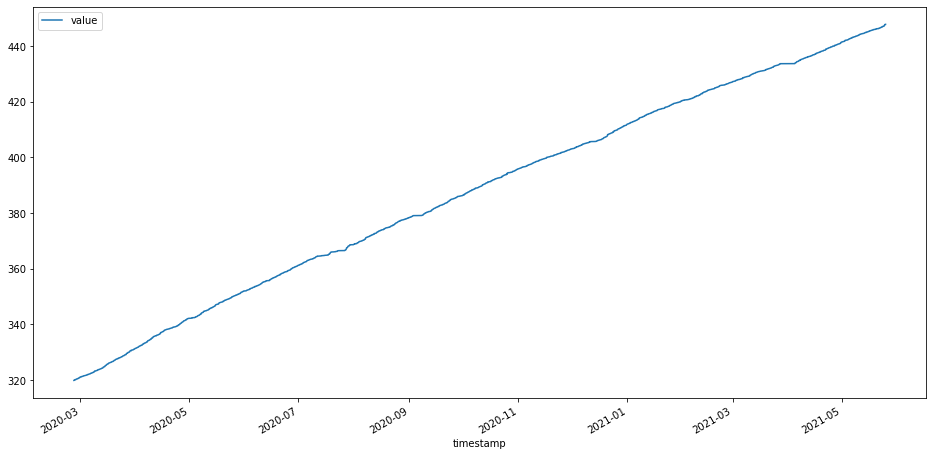

In [6]:
raw_df_filter.plot(figsize=(16,8))

# Daily resampled (At the end of the day)

In [7]:
daily_df = raw_df_filter.resample(rule='D').last()
daily_diff = daily_df.diff()

In [8]:
# Test if it is random walk using Dickey-Fuller test
# Since p-value < 0.05, we rejected null hypothesis, which states that Daily diffence is random walk
from statsmodels.tsa.stattools import adfuller
results = adfuller(daily_df.value)
print(results)

(-3.9325781322093203, 0.0018077510859217838, 1, 453, {'1%': -3.444868194858831, '5%': -2.867941416548597, '10%': -2.5701797149735146}, -575.0882560186693)


## Detect outliers based on daily difference

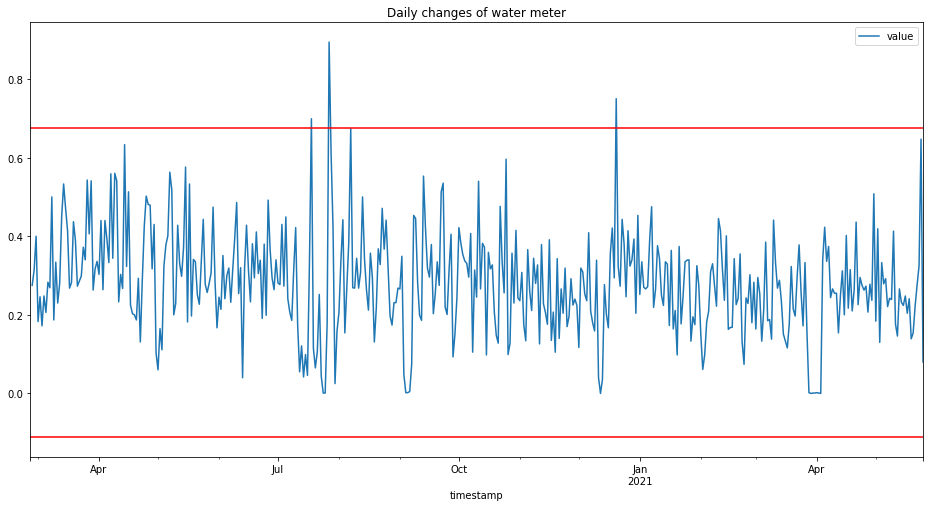

In [9]:
daily_diff.plot(figsize=(16,8))
mean = daily_diff['value'].mean()
std = daily_diff['value'].std()
factor = 3
plt.axhline(mean - factor*std, color='r')
plt.axhline(mean + factor*std, color='r')
plt.title('Daily changes of water meter')
plt.show()

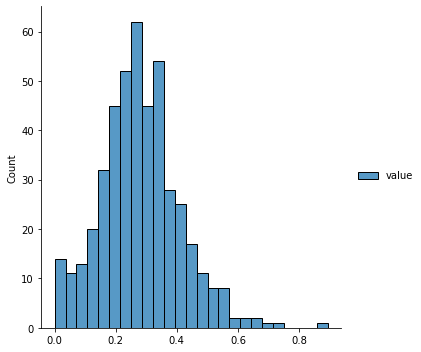

In [10]:
# Plot daily difference distribution
sns.displot(daily_diff)

In [11]:
daily_diff[daily_diff['value']>0.8]

,value
timestamp,
2020-07-27,0.894


<AxesSubplot:xlabel='timestamp'>

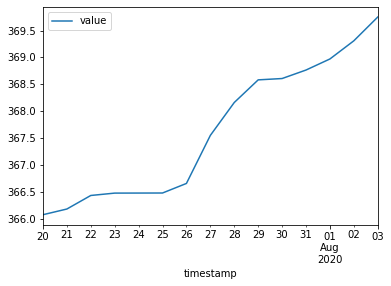

In [12]:
daily_df['2020-07-20':'2020-08-03'].plot()

In [13]:
daily_diff[daily_diff['value'] > 0.8]

,value
timestamp,
2020-07-27,0.894


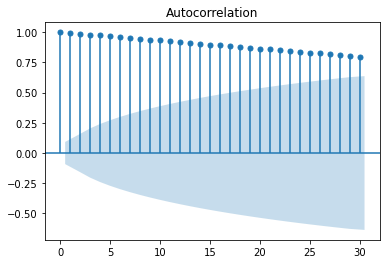

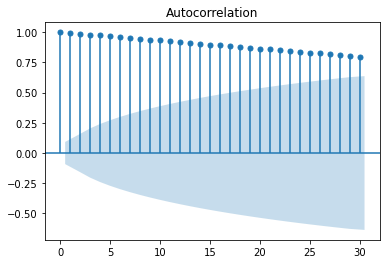

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(daily_df['value'], lags=30, alpha=.05)

## Pick model with lowest AIC

In [26]:
daily_diff = daily_diff[~daily_diff.value.isna()]

In [27]:
# Creat AR(1), AR(2), ARMA(1,1) and check AIC
from statsmodels.tsa.arima_model import ARMA
ar1 = ARMA(daily_diff.value, order=(1, 0))
res_ar1 = ar1.fit()
print('The AIC for an AR(1) is:', res_ar1.aic)

ar2 = ARMA(daily_diff.value, order=(2,0))
res_ar2 = ar2.fit()
print('The AIC for an AR(2) is:', res_ar2.aic)

arma11 = ARMA(daily_diff.value, order=(1, 1))
res_arma11 = arma11.fit()
print('The AIC for an ARMA(1, 1) is:', res_arma11.aic)

The AIC for an AR(1) is: -588.066105386768
The AIC for an AR(2) is: -589.2766035159193
The AIC for an ARMA(1, 1) is: -588.576348794674
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


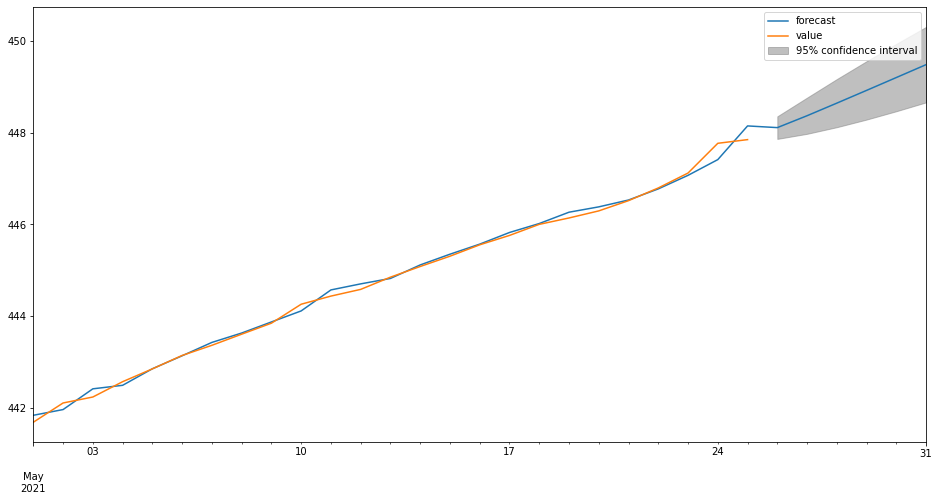

In [33]:
from statsmodels.tsa.arima_model import ARIMA

mod = ARIMA(daily_df.value, order=(2,1,0))
res = mod.fit()

# Plot thprint('AIC of this model: ', res.aic)e original series and the forecasted series
fig, ax = plt.subplots(figsize=(16,8))
res.plot_predict(start='2021-05-01', end='2021-05-31', ax=ax)
plt.show()

# Weekly Resampling and prediction model

              value
timestamp          
2020-03-01  321.251
2020-03-08  323.175
2020-03-15  325.660
2020-03-22  328.009
2020-03-29  330.773
2020-04-05  333.266
2020-04-12  336.139
2020-04-19  338.503
2020-04-26  340.810
2020-05-03  342.475


<AxesSubplot:xlabel='timestamp'>

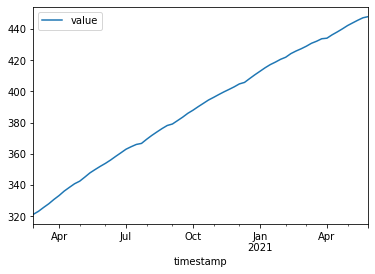

In [15]:
weekly_resample = raw_df_filter.resample(rule='W').last()
print(weekly_resample.head(10))
weekly_resample.plot()


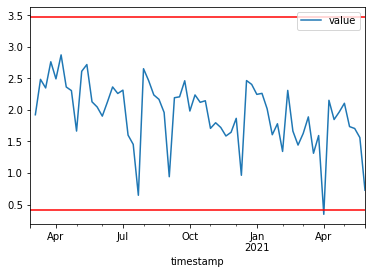

In [16]:
weekly_diff = weekly_resample.diff()
weekly_diff.plot()
mean = weekly_diff['value'].mean()
std = weekly_diff['value'].std()
factor = 3
plt.axhline(mean - factor*std, color='r')
plt.axhline(mean + factor*std, color='r')
plt.show()

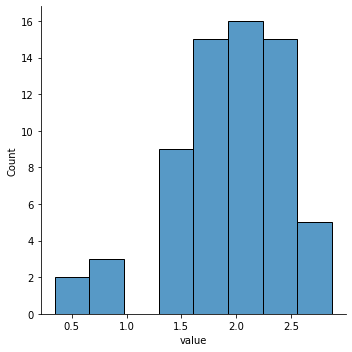

In [17]:
sns.displot(weekly_diff['value'])

In [18]:
weekly_diff[weekly_diff['value'] < 1.0]

,value
timestamp,
2020-07-26,0.647
2020-09-06,0.941
2020-12-13,0.964
2021-04-04,0.345
2021-05-30,0.727


In [19]:
weekly_autocorr = weekly_diff['value'].autocorr()
print('Weekly autocorrelation ', weekly_autocorr)

Weekly autocorrelation  0.2889318619258563


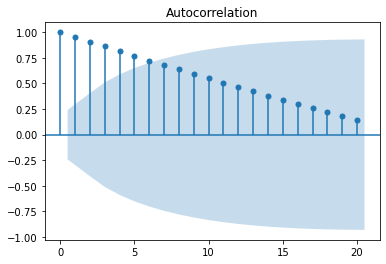

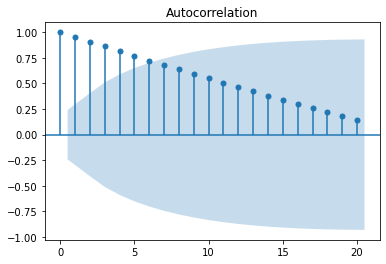

In [20]:
plot_acf(weekly_resample.value, lags=20, alpha=.05)

In [21]:
weekly_diff = weekly_diff[~weekly_diff.value.isna()]

In [22]:
# Creat AR(1), AR(2), ARMA(1,1) and check AIC
from statsmodels.tsa.arima_model import ARMA
ar1 = ARMA(weekly_diff.value, order=(1, 0))
res_ar1 = ar1.fit()
print('The AIC for an AR(1) is:', res_ar1.aic)

ar2 = ARMA(weekly_diff.value, order=(2,0))
res_ar2 = ar2.fit()
print('The AIC for an AR(2) is:', res_ar2.aic)

arma11 = ARMA(weekly_diff.value, order=(1, 1))
res_arma11 = arma11.fit()
print('The AIC for an ARMA(1, 1) is:', res_arma11.aic)

The AIC for an AR(1) is: 96.5125719278164
The AIC for an AR(2) is: 96.7668512518582
The AIC for an ARMA(1, 1) is: 97.40270545571735
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


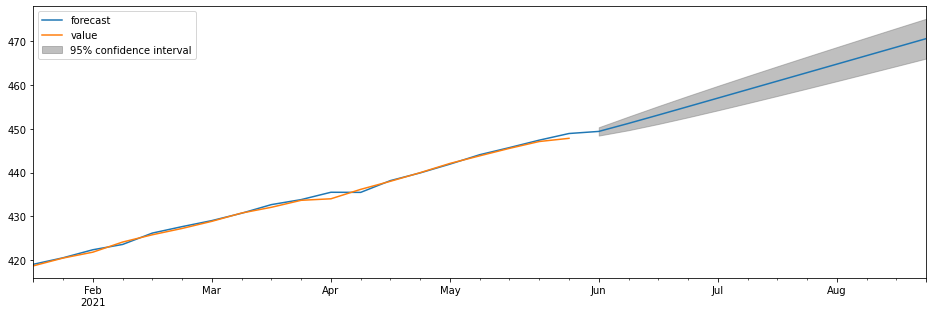

In [25]:
from statsmodels.tsa.arima_model import ARIMA

mod = ARIMA(weekly_resample.value, order=(1,1,0))
res = mod.fit()

# Plot thprint('AIC of this model: ', res.aic)e original series and the forecasted series
fig, ax = plt.subplots(figsize=(16,5))
res.plot_predict(start='2021-01-24', end='2021-08-21', ax=ax)
plt.show()